In [1]:
%matplotlib inline
import cPickle as pkl
import pandas as pd
import networkx as nx
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [2]:
rdata, udata, data, users, repos = pkl.load(open('data_structuring_150.pkl', 'rb'))

In [3]:
data.values()[:5]

[{'actions': [u'IssueCommentEvent'],
  'commits': 0,
  'time_buckets': [9],
  'times': [datetime.datetime(2015, 1, 26, 19, 5, 43)],
  'user_is_owner': False},
 {'actions': [u'CommitCommentEvent', u'CommitCommentEvent'],
  'commits': 0,
  'time_buckets': [1, 1],
  'times': [datetime.datetime(2015, 1, 1, 13, 17, 12),
   datetime.datetime(2015, 1, 1, 13, 18, 4)],
  'user_is_owner': False},
 {'actions': [u'PullRequestEvent'],
  'commits': 0,
  'time_buckets': [6],
  'times': [datetime.datetime(2015, 1, 17, 4, 17, 44)],
  'user_is_owner': False},
 {'actions': [u'IssuesEvent'],
  'commits': 0,
  'time_buckets': [6],
  'times': [datetime.datetime(2015, 1, 16, 21, 5, 43)],
  'user_is_owner': False},
 {'actions': [u'WatchEvent'],
  'commits': 0,
  'time_buckets': [2],
  'times': [datetime.datetime(2015, 1, 6, 15, 44, 47)],
  'user_is_owner': False}]

In [4]:
label_encodings = {'MemberEvent': "none",
 'PublicEvent': "design",
 'PullRequestReviewCommentEvent': "design",
 'ForkEvent': "consume",
 'GollumEvent': "design",
 'ReleaseEvent': "none",
 'PullRequestEvent': "content",
 'IssueCommentEvent': "design",
 'PushEvent': "content",
 'DeleteEvent': "content",
 'CommitCommentEvent': "design",
 'WatchEvent': "consume",
 'IssuesEvent': "design",
 'CreateEvent': "content"}

In [53]:
class MIPnet():
    def __init__(self, P, R, decay = 0.9):
        self.P = P # partner
        self.R = R # repos
        self.mip = nx.MultiGraph()
        self.mip.add_nodes_from(self.P, ntype="user")
        self.mip.add_nodes_from(self.R, ntype="repo")
        self.centrality = {}
        self.decay = decay
        
        
    # currently, user-user, repo-repo increase by max 1 in weight, 
    # could also be 1 per common edit
    def update_edges_for_time(self,ints):
        thisBucketUserRepos = defaultdict(set)
        thisBucketRepoUsers = defaultdict(set)
        # create or update user-repo edges and repo-repo edges
        for ix,i in enumerate(ints):
            cuser, crepo, ctype = i
            # repo-repo: create/update edge if not exists in current time
            if crepo not in thisBucketUserRepos[cuser] and len(thisBucketUserRepos[cuser]) > 0:
                for connectRepo in thisBucketUserRepos[cuser]:
                    if self.mip.has_edge(crepo, connectRepo):
                        self.mip[crepo][connectRepo][0]['weight']+=1
                    else:
                        self.mip.add_edge(crepo, connectRepo, weight=1, ntype='r-r')
            thisBucketUserRepos[cuser].add(crepo)

            # user-user, similar to repo-repo
            if cuser not in thisBucketRepoUsers[crepo] and len(thisBucketRepoUsers[crepo]) > 0:
                for connectUser in thisBucketRepoUsers[crepo]:
                    if self.mip.has_edge(cuser, connectUser):
                        self.mip[cuser][connectUser][0]['weight']+=1
                    else:
                        self.mip.add_edge(cuser, connectUser, weight=1, ntype='u-u')
            thisBucketRepoUsers[crepo].add(cuser)

            # user-repo
            edge_exists = False
            # check whether edge exists
            if (cuser, crepo, None) in self.mip.edges(cuser,crepo):
                # if yes, iterate over edges to find whether the correct edge exists
                for ednum,val in self.mip[cuser][crepo].iteritems():
                    if val['ntype'] == ctype:
                        edge_exists = True
                        self.mip[cuser][crepo][ednum]['weight']+=1
            if not edge_exists:
                self.mip.add_edge(cuser, crepo, weight=1, ntype=ctype)
        self.centrality = nx.degree_centrality(self.mip)
                
    def decay_weights(self):
        for u,v,d in self.mip.edges(data=True):
            d['weight'] = d['weight'] * self.decay
        

In [54]:
def get_all_interactions_for_timebucket(t):
    #creates a list of time
    counter = 0
    interactions = [] #user, repo, type
    for ix,key in data.iteritems():
        try: # there is one empty set in the data...
            for time, types in zip(key['time_buckets'], key['actions']):
                if time == t:
                    if not label_encodings[types] == "none":
                        interactions.append((ix[0], ix[1], label_encodings[types]))
                #print types, time, 
            counter +=1
#         if counter > 100:
#             print interactions
#             break
        except:
            pass 
    print "found", len(interactions), "interactions"
    return interactions


In [55]:
# Simulate time steps
mip = MIPnet(users, repos)
interactions_bucket1 = get_all_interactions_for_timebucket(1)
mip.update_edges_for_time(interactions_bucket1)

found 16194 interactions


In [61]:
# simulate all time buckets
mip = MIPnet(users, repos)
for i in range(1,10):
    print "Bucket", i
    mip.update_edges_for_time(get_all_interactions_for_timebucket(i))
    print len(mip.mip.edges()), "Edges between", len(users)+len(repos), "Nodes"
    mip.decay_weights()

Bucket 1
found 16194 interactions
34048 Edges between 26735 Nodes
Bucket 2
found 23973 interactions
65740 Edges between 26735 Nodes
Bucket 3
found 31620 interactions
95379 Edges between 26735 Nodes
Bucket 4
found 26499 interactions
120711 Edges between 26735 Nodes
Bucket 5
found 38469 interactions
172204 Edges between 26735 Nodes
Bucket 6
found 28763 interactions
199121 Edges between 26735 Nodes
Bucket 7
found 26121 interactions
226551 Edges between 26735 Nodes
Bucket 8
found 25313 interactions
251684 Edges between 26735 Nodes
Bucket 9
found 19782 interactions
271002 Edges between 26735 Nodes


In [28]:
for ednum,val in mip.mip["Angelfirenze"]["deadlyvipers/dojo_rules"].iteritems():
    print val

{'ntype': 'content', 'weight': 9.850707420300003}
{'ntype': 'design', 'weight': 3.4480423521000008}
{'ntype': 'consume', 'weight': 0.7791456501000001}


In [10]:
data[data.keys()[0]]

{'actions': [u'IssueCommentEvent'],
 'commits': 0,
 'time_buckets': [9],
 'times': [datetime.datetime(2015, 1, 26, 19, 5, 43)],
 'user_is_owner': False}

## Evaluation Section

### adjusted MIP-DOI

In [11]:
import math

In [12]:
# How much should each weight be worth? Start with equal
params = {"u-u": 1,
          "r-r": 1,
          "content": 1,
          "design": 1,
          "consume": 1,}
# Ofras parameters
alpha = .5
beta = .5

In [13]:
def connectionWeight(mip, n1,n2, gammas):
    weight = 0.0
    for ednum,val in mip[n1][n2].iteritems():
        weight+= val['weight'] * gammas[val['ntype']]
    return weight
def adamicAdarProximity(mip, s, t, gammas):
    proximity = 0.0
    if (mip.has_node(s)==False) | (mip.has_node(t)==False):
        return 0
    for node in nx.common_neighbors(mip, s, t):
        weights = connectionWeight(mip, s,node, gammas) + connectionWeight(mip, t,node, gammas)        
        if weights!=0: # 0 essentially means no connection
            # gives more weight to "rare" shared neighbors, adding small number to avoid dividing by zero
            proximity = proximity + (weights*(1/(math.log(mip.degree(node, weight = 'weight'))+1e-9))) 
    return proximity
adamicAdarProximity(mip.mip, "Angelfirenze", "deadlyvipers/dojo_rules", params)
#TODO rescale both values or learn alpha/beta

24.76481103028371

In [73]:
def computeDOI(mip, u, r, params):
    # precomputed centrality + scaling factor
    API = mip.centrality[r] #* 100
    prox = adamicAdarProximity(mip.mip,u,r, params)
    #print API, prox
    return alpha * API + beta * prox, API, prox
computeDOI(mip, "Angelfirenze", "deadlyvipers/dojo_rules", params)


(6.623521370480484, 0.0005984888157402558, 13.246444252145228)

## Test 1: Predict interactions from only DOI vs. linear model using DOI

In [74]:
from collections import Counter

In [158]:
test_ints[0:5]#label_encodings

[(u'asterite', u'manastech/crystal', 'design'),
 (u'asterite', u'manastech/crystal', 'content'),
 (u'jfryman', u'StackStorm/st2', 'design'),
 (u'cjihrig', u'joyent/node', 'design'),
 (u'cjihrig', u'joyent/node', 'design')]

In [170]:
test_ints = get_all_interactions_for_timebucket(10)
y_truths = Counter()
for p in test_ints:
    if p[2] == 'consume':
        y_truths[(p[0],p[1])] = 1

found 22769 interactions


In [171]:
X = []
Y = []
for ix, u in enumerate(users):
    #print udata[u]['repos']
    current_list = []
    for ix2, r in enumerate(repos):
        doi, api, prox =  computeDOI(mip,u,r,params)
        current_list.append((doi,r,api,prox))
#         if ix2 > 20:
#             break
    #current_list.sort()
    for bla in current_list:#[-100:]:
        if y_truths[(u,bla[1])] == 1:
            X.append([bla[2], bla[3]])
            Y.append(y_truths[(u,bla[1])])
        elif np.random.rand() > .95:
            X.append([bla[2], bla[3]])
            Y.append(y_truths[(u,bla[1])])
    if ix % 100 == 0:
        print ix
    if ix > 1000:
        break
X = np.array(X)
Y = np.array(Y)

0
100
200
300
400
500
600
700
800
900
1000


In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr

In [172]:
model = LogisticRegression()
model.fit(X,Y)
model.coef_#scores = cross_val_score(model, X, Y, cv=5, scoring='f1')

array([[ 0.13764985,  0.05271238]])

In [173]:
pos = X[[Y==1]]
neg = X[[Y==0]]

In [174]:
print pos[:,0].mean(), neg[:,0].mean()
print pos[:,1].mean(), neg[:,1].mean()

0.00242258196014 0.000916964599455
0.600655080571 0.0194973863312


In [175]:
y_hat = model.decision_function(X)
y_hat_preds = model.predict(X)

In [176]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

In [177]:
print "Accuracy {}".format(accuracy_score(Y, y_hat_preds))
print classification_report(Y, y_hat_preds)

Accuracy 0.999807676834
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    509461
          1       0.00      0.00      0.00        98

avg / total       1.00      1.00      1.00    509559



/Users/Sebastian/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [178]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y, y_hat)
auc = roc_auc_score(Y, y_hat)

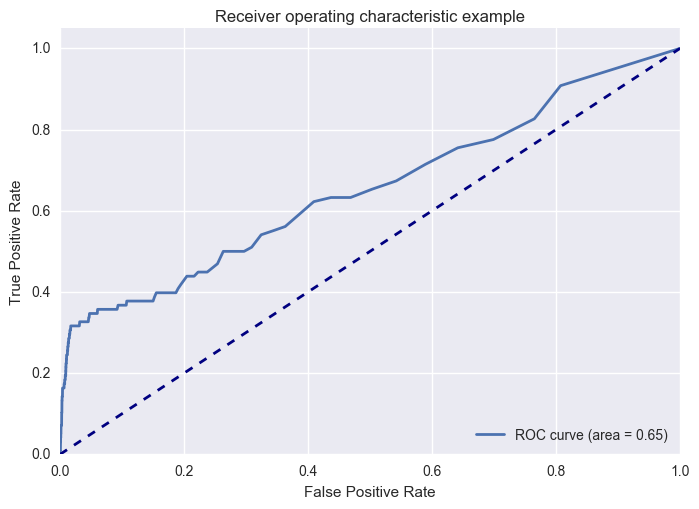

In [179]:
plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()